# Lake_Bilancino
This is an artificial lake near Florence made with a dam on the river Sieve. It holds 69 km³ of water, is 31 metres at its deepest point and, covers an area of 5km². The task is to predict the Lake Level and Flow Rate for the next day from historical Rainfall, Temperature, Lake Level and Flow Rate data. 

## Our Understanding of the Lake Mechanics
The daily change in the lake water volume is the sum of the inflows less the sum of the outflows which for this model we assume:
1. The inflow is just from the rain runoff in the catchment area.   
2. The outflows are just evaporation and river outflows. 

This ignores losses due to seepage into the ground (likely to be small) or inflows from underground reserves.

### Rainfall
We are provided with the 24hr rainfall data for the catchment area. Not all this rainfall will end up 
in the dam, i.e.,some will seep into the ground, evaporate or be lost to other rivers/catchments. 
It is likely that it will take hours or days for the rainfall to arrive at the Lake and the inflow 
may be spread over several days.  We explore this below by looking at cross correlations between the 
daily lake level changes and the rainfall. We see correlations at days 0, -1, -2, and -3, with the 
peak correlation at day -1, i.e., the average lag between the rain falling and the inflow is 1 day.  
Since these Rainfall measurements are from adjacent areas it is likely they are highly correlated
and we explore this below. 

### Evaporation
The key factors affecting evaporation are
* Temperature: As the temperature increases, the rate of evaporation also increases. 
* Surface area: As the surface area increases, the rate of evaporation increases. 
* Humidity: The rate of evaporation decreases with an increase in humidity. 
* Wind speed: Increase in wind speed results in increased evaporation. 

The only data we are provided is the Temperature.  As the surface areas does not vary greatly on a daily basis this can safely be ignored. The importance of humidity and/or wind speed is unknown and may need to be investigated but is ignored in the following models.

### River Outflow
While we are given this it is considered to be an target (or output) variable. This means we can't use "tomorrows" river outflow when predicting "tomorrows" Lake Level. Instead we need to predict the River Outflow and use that. In the modeling below we find that simply using today's outflow in the model provides a prediction that is very close to using the actual measured outflow from "tomorrow". 

In many damns the outflow is manually controlled to manage the lake levels so that:
1. Below a specific level the outflow is a constant low amount, typically designed to maintain the health of the associated downstream water ecosystem.
2. Above a specific level the outflow increases and to maintain some optimal Lake Level range. 

This manual control may have significant impact on modeling the River Outflow. Specifically the relationship between Lake Level and River Outflow may inherently be nonlinear and, the relationship may suddenly and unpredictably change if the policy on how outflow is managed is changed. We see evidence for both in the analysis below.

### Lake Level
We assume the change in Lake Level is proportional to the change in lake volume (i.e., inflows - outflows). Since the lake has an irregular volumetric profile the change in level is not exactly proportional to volume, and may be dependant on the Lake Level, but this is a reasonable approximation for daily changes.

This means that input variables (i.e., Rainfall, Temperature) will be correlated with Lake Level Changes (though the change in volume) rather than with the Lake Level. This is because the Lake Level is the accumulation of all the prior Lake Level Changes.  This is clearly seen below in the correlation between Rainfall and Lake Level and Lake Level Changes and with autocorrelation plots.  


## Summary
Based on this understanding of the physical model, our hypothesis is the daily Lake Levels Changes are driven by the inflow of rain from the last few days less the outflows from evaporation and the flow rate and, the Lake Levels are calculated by adding this change to the current level. We use these insights into the physical model to drive the Exploratory Data Analysis, Feature Engineering and Modeling below.

We note that modeling the daily change in Lake Level is appropriate when forcasting the next day (1-steps) or a few days, however if the objective was to forecast many weeks or months in advance, this may be a poor approach as the cumulative errors from recursively estimating the n-th day base on the prediciton of the (n-1)-th day will reduce the accuracy. For this kind of forecasting, we would instead focus on the Lake Level and break up the Date in to its parts, i.e, Year, Month etc, rather than emphaisise the lagged variables. 

# Forecasting Time Series
As as aside, when forecasting with a Time Series there are a few tricks that are commonly employed toget good results. It is common to 
1. create new features like Month, or Day of Week from the date. This was attempted and we found these did not significanlty improve the model predication. 
2. to include lagged versions of a feature, like rainfall. We found that including 3 days of prior rainfall data had a significant improvement. This is intuatively obvious from the physical model as the rain may take a few days to arrive at the dam.
3. transform the output (target) variable into something that is more easily correlated with the inputs (features). We found that workign with the Lake Level Change improved model performance and agaain the reasons for this are obvious from the physical model. We also note that it can be shown using simple algera that the MAE for Lake Level Change is the same for Lake Level derived from that (i.e., Lake Level CHange = Yesterday's Lake Level + Lake Level Change).

The other key to time series is the data train/test split. In non-time seriers the data is usually split randomly, often using a KFold method, however with Time series it is important to slit the data by time so that the train data set does not inadvertantly include data from test set. Since this problem includes two target variables (Lake Level and Flow Rate), we also need to ensure the training data does not use the current version of these. However, it is possible to cinlude lagged versions of these variables. 

In short, Time Series have some additional properties that need to be properly handeled to get a valid and proper prediction.

In [1]:
import os
import numpy as np
import pandas as pd
import missingno as msno
import sys

import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rcParams['figure.figsize'] = (16, 4)
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

from termcolor import colored

In [2]:
dfs = dict()
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.csv'):
            name = filename[:-4]
            dfs[name] = pd.read_csv(os.path.join(dirname, filename), parse_dates=['Date'], dayfirst=True)

In [3]:
def missing(df):
    return df.isnull().sum()/len(df)*100
    
def date_features(df):
    df['Year'] =  df.index.year
    df['Month'] =  df.index.month
    df['Day_of_Year'] =  df.index.dayofyear
    # df['dayofweek'] =  df.index.dayofweek
    df['Day_Name'] =  df.index.day_name()
    df['Week_of_Year'] =  df.index.weekofyear

In [4]:
dfs_time = pd.DataFrame(dfs.keys(), columns=['name'])
dfs_time['first_date'] = [dfs[key]['Date'].min() for key in dfs]
dfs_time['last_date'] = [dfs[key]['Date'].max() for key in dfs]
dfs_time['duration'] = (dfs_time['last_date'] - dfs_time['first_date']).apply(lambda x: x.days)+1
dfs_time['unique_days'] = [dfs[key]['Date'].nunique() for key in dfs]
dfs_time['missing_days'] = dfs_time['duration']-dfs_time['unique_days']
dfs_time['null_rows'] = [dfs[key].isnull().all(axis='columns').sum() for key in dfs]
dfs_time['null_date'] = [dfs[key]['Date'].isnull().sum() for key in dfs]
dfs_time['missing_data'] = [dfs[key].isnull().sum().sum() for key in dfs]

dfs_time.sort_values("missing_data")[['name', 'first_date', 'last_date', 'missing_days', 'null_rows', 'null_date', 'missing_data']]

,name,first_date,last_date,missing_days,null_rows,null_date,missing_data
7,Water_Spring_Lupa,2009-01-01,2020-06-30,0,0,0,382
4,Water_Spring_Madonna_di_Canneto,2012-01-01,2020-06-30,0,9,9,2847
3,Lake_Bilancino,2002-06-03,2020-06-30,0,0,0,3484
6,Aquifer_Petrignano,2006-03-14,2020-06-30,0,0,0,4388
2,Water_Spring_Amiata,2000-01-01,2020-06-30,0,0,0,61607
1,Aquifer_Auser,1998-03-05,2020-06-30,0,0,0,64410
8,River_Arno,1998-01-01,2020-06-30,0,0,0,67690
0,Aquifer_Doganella,2004-01-01,2020-06-30,0,0,0,73392
5,Aquifer_Luco,2000-01-01,2020-06-30,0,0,0,80610


In [5]:
dfs['Water_Spring_Madonna_di_Canneto'].dropna(subset=['Date'], inplace=True)
for key in dfs:
    dfs[key].set_index('Date', drop=True, inplace=True, verify_integrity=True)

## Exploratory Data Analysis
The data includes: 
* Rainfall for 5 catchment areas
* Temperature for Le Croci, which is close to the lake
* Lake Level and output Flow Rate which are the targets

### Missing Data
The visualizations below show there is daily data from 2002-06-03 to 2020-06-30, however the 2002 and 2003 data is missing all Rainfall data. We will drop data before 2004.

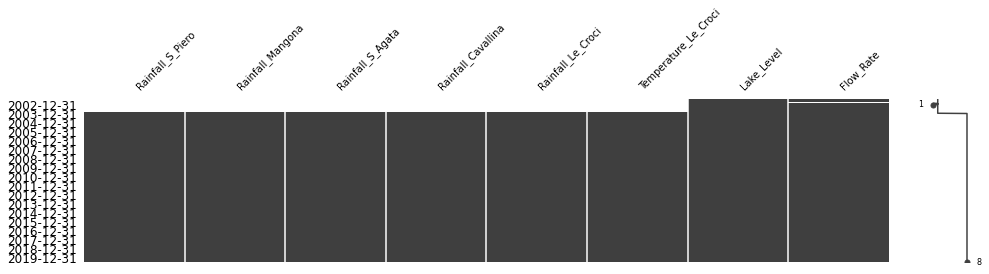

In [6]:
msno.matrix(dfs["Lake_Bilancino"], freq="Y", figsize=(16, 3), fontsize=10);

## Seasonality
The charts below show the lake level has seasonal variation, that is similar across the years, however it's not clear how this relates to the Total Rainfall or the Flow Rate. 

We note the Lake Level has a sharp rise in January that flattens out. This pattern is consistent with practice of using Flow Rate to constrain the level at some maximum level as noted above.

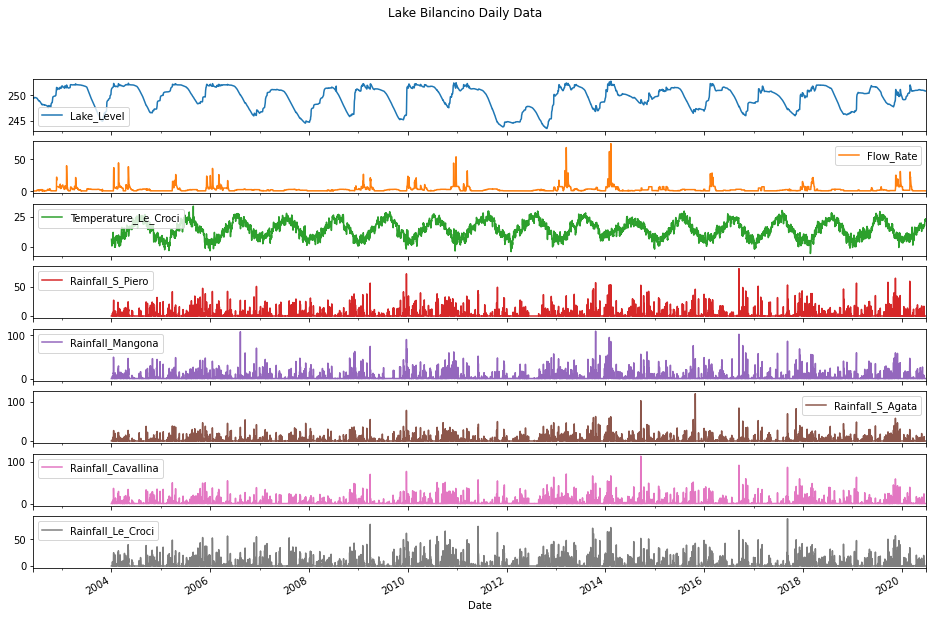

In [7]:
dfs["Lake_Bilancino"][['Lake_Level', 'Flow_Rate','Temperature_Le_Croci','Rainfall_S_Piero','Rainfall_Mangona', 
                       'Rainfall_S_Agata', 'Rainfall_Cavallina', 'Rainfall_Le_Croci']].\
                        plot(title='Lake Bilancino Daily Data', subplots=True, figsize=(16, 10));

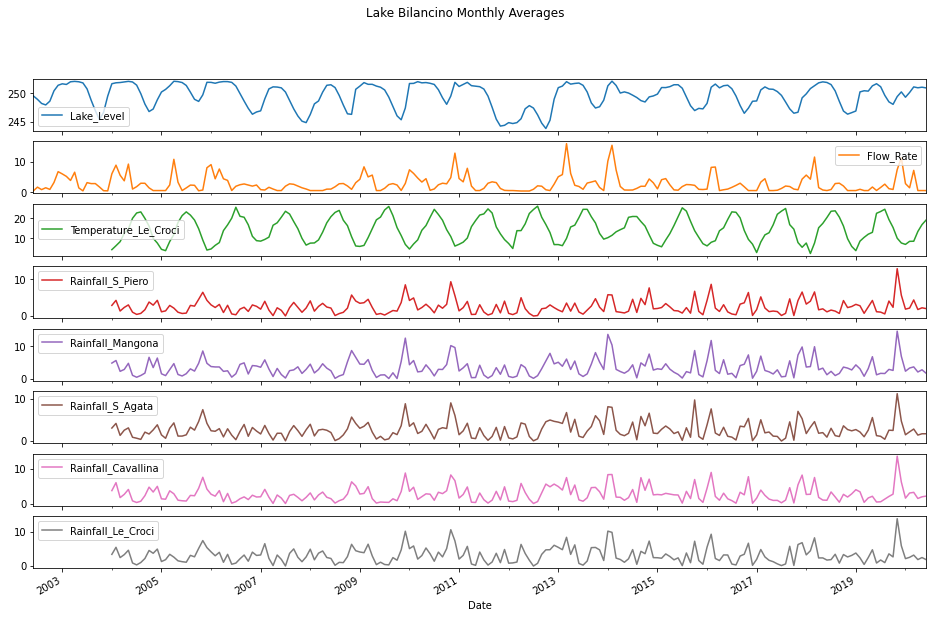

In [8]:
dfs["Lake_Bilancino"][['Lake_Level', 'Flow_Rate','Temperature_Le_Croci','Rainfall_S_Piero','Rainfall_Mangona', 
                       'Rainfall_S_Agata', 'Rainfall_Cavallina', 'Rainfall_Le_Croci']].resample("M").mean().\
                        plot(title='Lake Bilancino Monthly Averages', subplots=True, figsize=(16, 10));

From the Augmented Dickey Fuller test we conclude that the Lake_Level is a stationary time series, which means the statistical properties (i.e., mean, variance, autocorrelation) are constant over time. The same is true of Flow Rate

In [9]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(dfs["Lake_Bilancino"].Lake_Level)
print('Lake Level ADF Statistic: {:.3f},p-value: {:.3f}'.format(result[0], result[1]))
from statsmodels.tsa.stattools import adfuller
result = adfuller(dfs["Lake_Bilancino"].Flow_Rate['2004':'2020'])
print('Flow Rate ADF Statistic: {:.3f},p-value: {:.3f}'.format(result[0], result[1]))

Lake Level ADF Statistic: -6.881,p-value: 0.000
Flow Rate ADF Statistic: -10.093,p-value: 0.000


## Correlation
The correlation matrix below shows the 5 rainfall measurements are highly correlated (0.87 < r < 0.92) to each other (in red), which may cause issues with Linear Regression models. One option is to sum these into a Total Rainfall, which has a similar correlation to Lake Level and Lake Level Change as the individual rainfalls. 

In [10]:
rainfall=['Rainfall_Le_Croci', 'Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata', 'Rainfall_Cavallina']
dfs["Lake_Bilancino"]['Total_Rainfall'] = dfs["Lake_Bilancino"][rainfall].sum(axis=1)
dfs["Lake_Bilancino"]['Lake_Level_Change'] = dfs["Lake_Bilancino"].Lake_Level.diff()

In [11]:
col_order = ['Rainfall_Le_Croci', 'Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata', 'Rainfall_Cavallina', 'Total_Rainfall', 'Temperature_Le_Croci', 'Flow_Rate', 'Lake_Level', 'Lake_Level_Change']
dfs["Lake_Bilancino"][col_order].corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,Rainfall_Le_Croci,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Total_Rainfall,Temperature_Le_Croci,Flow_Rate,Lake_Level,Lake_Level_Change
Rainfall_Le_Croci,1.00,0.91,0.86,0.88,0.92,0.96,-0.14,0.19,-0.02,0.24
Rainfall_S_Piero,0.91,1.00,0.87,0.90,0.91,0.96,-0.13,0.14,-0.03,0.25
Rainfall_Mangona,0.86,0.87,1.00,0.87,0.87,0.94,-0.13,0.17,-0.03,0.28
Rainfall_S_Agata,0.88,0.90,0.87,1.00,0.89,0.95,-0.12,0.16,-0.03,0.25
Rainfall_Cavallina,0.92,0.91,0.87,0.89,1.00,0.96,-0.13,0.17,-0.03,0.25
Total_Rainfall,0.96,0.96,0.94,0.95,0.96,1.00,-0.14,0.17,-0.03,0.25
Temperature_Le_Croci,-0.14,-0.13,-0.13,-0.12,-0.13,-0.14,1.00,-0.20,0.06,-0.21
Flow_Rate,0.19,0.14,0.17,0.16,0.17,0.17,-0.20,1.00,0.30,0.07
Lake_Level,-0.02,-0.03,-0.03,-0.03,-0.03,-0.03,0.06,0.30,1.00,0.02
Lake_Level_Change,0.24,0.25,0.28,0.25,0.25,0.25,-0.21,0.07,0.02,1.00


With this understanding we eliminate the individual rainfall data from the correlation matrix to more clearly show the key relationships between input and output variable:
* Lake Level Change (r = 0.25) and Flow Rate (r = 0.17) are weakly correlated to Total Rainfall 
* Flow Rate is weakly correlated to Temperature (-0.2) 
* Lake Level Change and Flow Rate are weakly correlated (0.30).

In [12]:
col_order = ['Total_Rainfall', 'Temperature_Le_Croci', 'Lake_Level_Change', 'Lake_Level', 'Flow_Rate']
dfs["Lake_Bilancino"][col_order].corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,Total_Rainfall,Temperature_Le_Croci,Lake_Level_Change,Lake_Level,Flow_Rate
Total_Rainfall,1.00,-0.14,0.25,-0.03,0.17
Temperature_Le_Croci,-0.14,1.00,-0.21,0.06,-0.20
Lake_Level_Change,0.25,-0.21,1.00,0.02,0.07
Lake_Level,-0.03,0.06,0.02,1.00,0.30
Flow_Rate,0.17,-0.20,0.07,0.30,1.00


### Conclusion
As expected by our physical model:
1. The 5 rainfall measurements are highly correlated and can be replaced by a single Total Rainfall
2. The Rainfall is not correlated to the Lake Level but has weak correlation to Lake Level Change 
2. The Flow Rate and Lake Level are weakly correlated

## Impact of flow rate
Based on proposed physical model of how Flow Rate is used to control the Lake Levels we hypothesise that below a specific Lake Level the Flow Rate is held at a low, constant value, and above that level the Flow Rate is controlled to hold the Lake Level near some optimal value. If this is correct then:
1. A plot of Lake levels vs Flow Rate will be flat in low mode, then have a sharp knee at the transition level, then rise sharply.
2. The correlation between Rainfall and Lake Level Change should be high in the low level mode, but weak in the high level mode.

The first chart below,  Lake Level vs Flow Rate, follows this pattern with some yearly variation.  When broken out by year this shows that prior to 2016 the strategy was to have a low flow up to a Lake Level of 252, then the Flow Rate increase rapidly to keep the Lake Level near that value. However, from 2016 onward the strategy seems to have changed and the flow was slow increased after a lake level of 250.

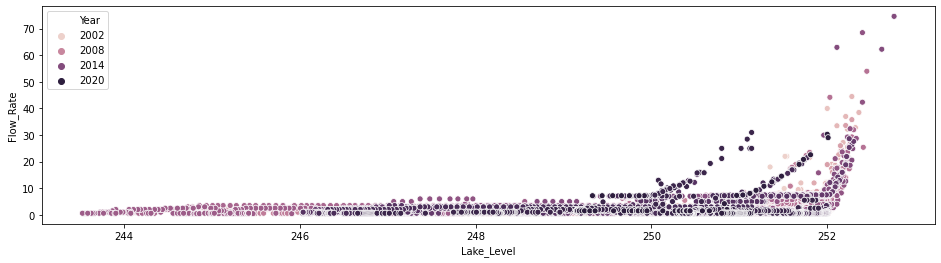

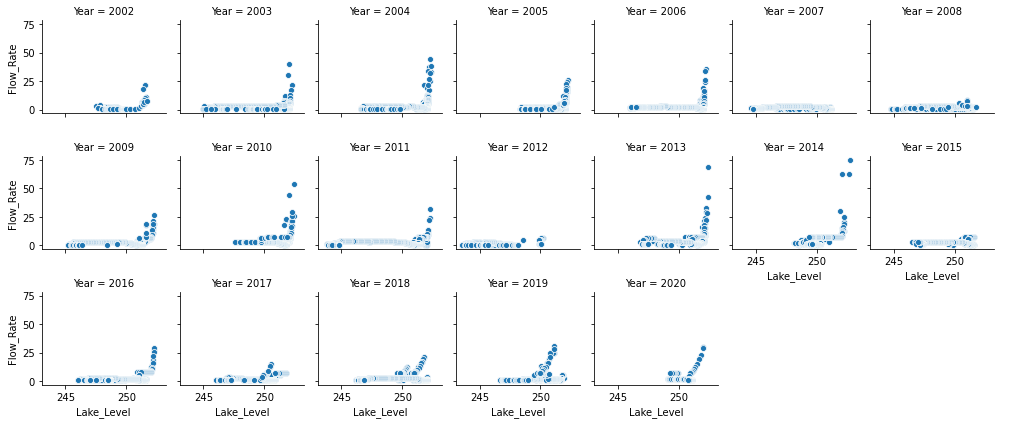

In [13]:
dfs["Lake_Bilancino"]['Year'] = dfs["Lake_Bilancino"].index.year
sns.scatterplot(data=dfs["Lake_Bilancino"],x='Lake_Level', y= 'Flow_Rate', hue="Year")
g = sns.FacetGrid(data=dfs["Lake_Bilancino"],col_wrap=7, col="Year", height=2)
g.map(sns.scatterplot, "Lake_Level", "Flow_Rate")
g.add_legend();

## Cross correlation and lag
The physical model suggests it will take time for the rainfall to reach the lake so we look at the cross correlation of the Lake Levels Change with Rainfall. This shows clear peaks at Day -1 with correlations ranging from Day 0 to -3, i.e., the rain takes 0 to 3 days to reach the lake. This suggest our model should include **lagged** Rainfall features.

We did not find any notable cross correlations with the other features.

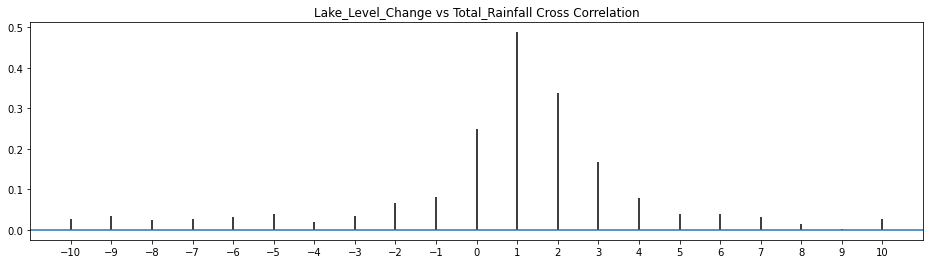

In [14]:
x=dfs["Lake_Bilancino"].Lake_Level_Change['2004':'2020']
y=dfs['Lake_Bilancino']['2004':'2020'].Total_Rainfall
plt.xcorr(x, y, maxlags=10);
plt.title("Lake_Level_Change vs Total_Rainfall Cross Correlation");
plt.xticks(np.arange(-10, 11, 1));

The following autocorrelation and partial correlation plots shows strong correlation of the Lake level with prior days, which from the physical model is to be expected. For time series with a large autocorrelation the common solution is to take the difference, i.e., Lake Level Change.  The autocorrelation plot for the Lake Level Change shows that this first difference shows the autocorrelation is greatly reduce. From the Partial Autocorreation we see some residue correlation with the prior day's Lake Level Change, indicating we should include this as a lagged feature. 

This supports the conjecure from the physical model that we focus on predicting the Lake Level Change, then add that to the prior day's Lake Level to predict the Lake Level. 

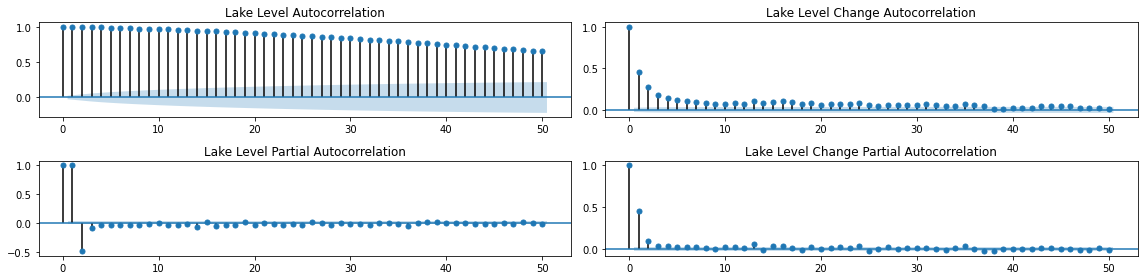

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axs = plt.subplots(2, 2)
plot_acf(x=dfs["Lake_Bilancino"].Lake_Level['2004':'2020'], lags=50, title="Lake Level Autocorrelation", ax=axs[0, 0]);
plot_acf(x=dfs["Lake_Bilancino"].Lake_Level_Change['2004':'2020'], lags=50, title="Lake Level Change Autocorrelation",ax=axs[0, 1]);

plot_pacf(x=dfs["Lake_Bilancino"].Lake_Level['2004':'2020'], lags=50, title="Lake Level Partial Autocorrelation", ax=axs[1, 0]);
plot_pacf(x=dfs["Lake_Bilancino"].Lake_Level_Change['2004':'2020'], lags=50, title="Lake Level Change Partial Autocorrelation", ax=axs[1,1]);
plt.tight_layout();

Similarly the Flow Rate has a strong autocorrelation with the prior day which is removed by taking the first difference. This might be an indication that should try to predict the change in Flow Rate too.

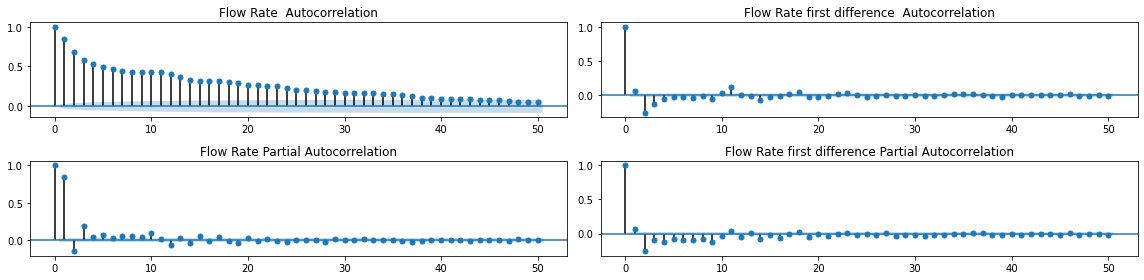

In [16]:
fig, axs = plt.subplots(2, 2)

plot_acf(dfs["Lake_Bilancino"].Flow_Rate['2004':'2020'], lags=50, title="Flow Rate  Autocorrelation",  ax=axs[0, 0]);
plot_acf(dfs["Lake_Bilancino"].Flow_Rate.diff()['2004':'2020'], lags=50, title="Flow Rate first difference  Autocorrelation",  ax=axs[0, 1]);

plot_pacf(dfs["Lake_Bilancino"].Flow_Rate['2004':'2020'], lags=50, title="Flow Rate Partial Autocorrelation",  ax=axs[1, 0]);
plot_pacf(dfs["Lake_Bilancino"].Flow_Rate.diff()['2004':'2020'], lags=50, title="Flow Rate first difference Partial Autocorrelation",  ax=axs[1, 1]);
plt.tight_layout();

### Conclusion
The conclusion 
1. The predictive model should use Lake Level Change as the target
2. The Flow Rate is higly dependant on the prior day's flow rate. 

## Variables

The Temperature and Lake Level Changes (below) have a normal like distribution where as Total Rainfall is skewed and may result in a poor prediction for linear regression models.  We note there are not clear cut correlations between these Rain Fall, Lake Level Change and Temp.

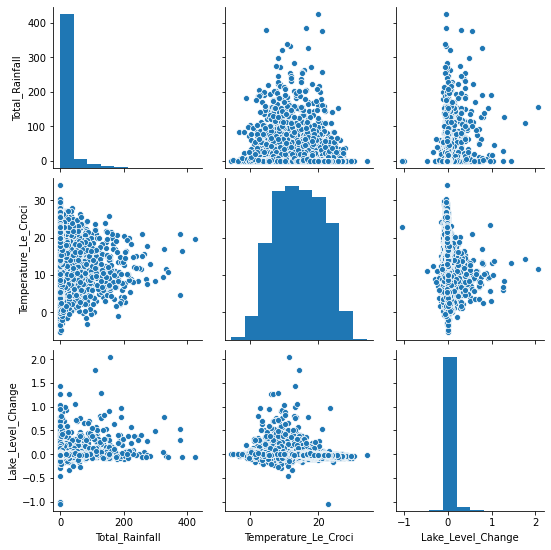

In [17]:
sns.pairplot(dfs["Lake_Bilancino"][['Total_Rainfall', 'Temperature_Le_Croci', 'Lake_Level_Change']]);

# Feature Engineering
Based on the the Exploratory Data Analysis we add the follow
- Lake level Change and Flow Rate Change, which are target variables.
- Total Rainfall and 3 days of Lagged Total Rainfall
- 1 day of Lagged Lake Level, Lake Level Changes, Flow Rate and Flow  Rate Change
- The Year and Day of Year, which from experimentation are the only date features of importance

In [18]:
for i in range(1, 4):
    dfs["Lake_Bilancino"]['Total_Rainfall-{}'.format(i)] = dfs["Lake_Bilancino"].Total_Rainfall.shift(i)

dfs["Lake_Bilancino"]['Flow_Rate-1']  = dfs["Lake_Bilancino"]['Flow_Rate'].shift() 
dfs["Lake_Bilancino"]['Lake_Level-1']  = dfs["Lake_Bilancino"]['Lake_Level'].shift()
dfs["Lake_Bilancino"]['Lake_Level_Change-1']  = dfs["Lake_Bilancino"]['Lake_Level_Change'].shift()
dfs["Lake_Bilancino"]['Flow_Rate_Change'] = dfs["Lake_Bilancino"].Flow_Rate.diff()
dfs["Lake_Bilancino"]['Flow_Rate_Change-1'] = dfs["Lake_Bilancino"].Flow_Rate_Change.shift()
dfs["Lake_Bilancino"]['Day_of_Year'] =  dfs["Lake_Bilancino"].index.dayofyear 

## Lake Level Modeling
In this section we will explore a number of models using the insights gathered so far. Specifically, 
* Discard data prior to 2004-01-02 due to missing data.
* Use Lake Level Change as the Target.
* Use Total Rainfall and drop the individual rainfall features.
* Incorporate and proposed lagged features.
* Hold back data from 2019 and 2020 for validation.

In [19]:

from sklearn.linear_model import LinearRegression
from sklearn import metrics

def score(target, test, pred, ax=None, title = None): 
    mae = metrics.mean_absolute_error(test, pred)
    rmse = metrics.mean_squared_error(test, pred)
    
    if ax == None:
        fig, ax = plt.subplots(1)
    pd.DataFrame({'Actual': test, 'Predicted': pred}).plot(ax=ax, title=title)
    ax.set_xlabel('Date')
    ax.set_ylabel(target)
    ax.legend([target, 'Predicted (MAE: {:.5f}, RMSE {:.5f})'.format(mae, rmse)]);

    return mae


train = dfs["Lake_Bilancino"]['2004-01-02':'2018']
test  = dfs["Lake_Bilancino"]['2019':'2020']

### Base line model
We consider three base line models for lake level change
* The lake level does not change. MAE: 0.04850 
* The lake level change is the same as today. MAE: 0.04442

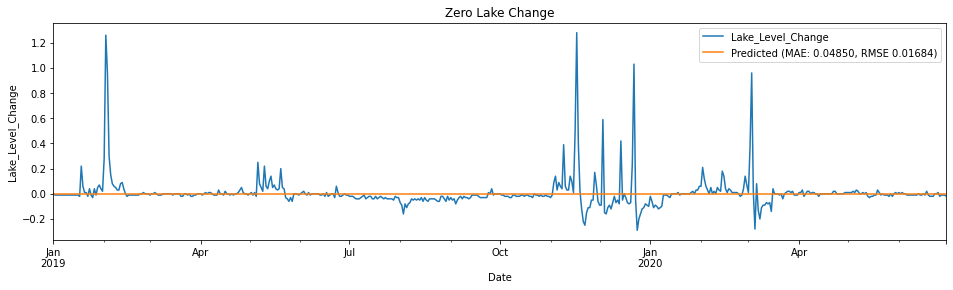

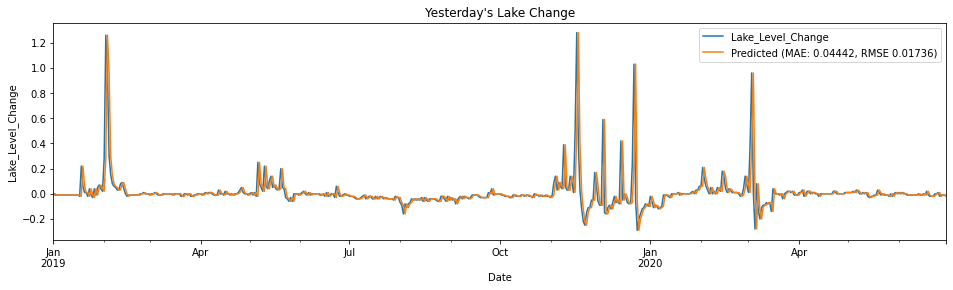

In [20]:
score('Lake_Level_Change', test['Lake_Level_Change'], [0]*len(test), title="Zero Lake Change");
score('Lake_Level_Change', test['Lake_Level_Change'], test['Lake_Level_Change-1'], title="Yesterday's Lake Change");

## Linear Regression Models
In this section we explore a few linear models using different feature sets inorder to understand feature importance and discover better models.  

We start with the basic features set of Temperature; Total Rainfall; 1, 2 & 3 day lagged Rainfall; and yesterday's Flow Rate. These features cover the key drivers of the inflow/outflow in our physical model, with the lagged Flow_Rate being used as an estimate of the Flow Rate. Obviously we can't use the actual Flow Rate as it unknown at the time of the prediction, but surprisingly we found using lagged Flow Rate gave a lower MAE.

This simple model (below) reflects the structure of the Lake Level Changes, i.e., the timing of most peaks and troughs, however the magnitudes are incorrect. We can see that Flow_Rate-1 has the largest importance, followed by Total_Rainfall-1. Indeed the feature importance very nicely fits our physical model (i.e., inflows - outflow) and the cross correlations.

This model has an  MAE  of 0.04575, which is 3% higher (worse) than the baseline model that simply uses yesterday's Lake Level Changes (MAE of 0.04442).

In [21]:
def featurePlot(features, model, ax):
    importance = model.coef_
    pd.DataFrame(data={'importance': importance}, index=features ).sort_values(["importance"]).plot.barh(ax=ax)
    

def linearModel(target, features, fromDate = '2004-01-02'):
    train = dfs["Lake_Bilancino"][fromDate : '2018']
    test  = dfs["Lake_Bilancino"]['2019':'2020']
    model = LinearRegression(normalize=True).fit(train[features], train[target])
    pred = model.predict(test[features])
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    score(target, test[target], pred, ax0)
    featurePlot(features, model, ax1)
    plt.tight_layout()
    return pred

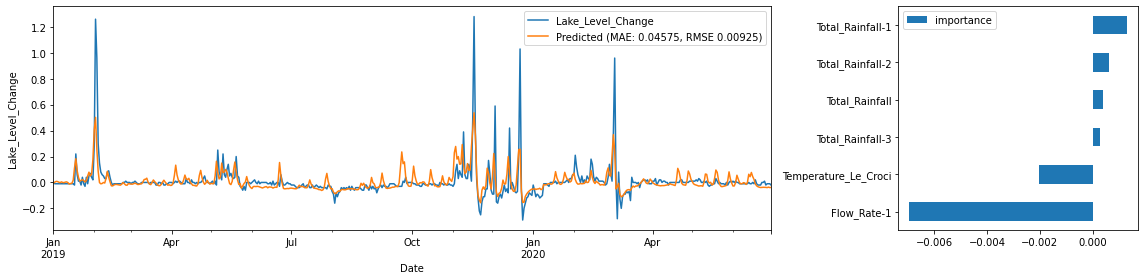

In [22]:
base_features = ['Total_Rainfall', 'Total_Rainfall-1', 'Total_Rainfall-2', 'Total_Rainfall-3', 'Temperature_Le_Croci', 'Flow_Rate-1']
linearModel('Lake_Level_Change', base_features);

With some experimentation we found that adding lagg features for each of Flow_Rate, Lake_Level_Change, Lake_Level yielded the best mode with an MAE of 0.04141, which is 6.7% better than the baseline. The feature importance plost show that the prior Lake_Level_Change is the most important feature and Total Rainfall and and the 2 and 3 day lagged versions have no impact. The feature importance no longer reflects the physical model and it appears that much of the information is captured in the lagged Lake Level Change.

Again we see the model large predicts the timing of the peaks, but again the magnitude is incorrect.

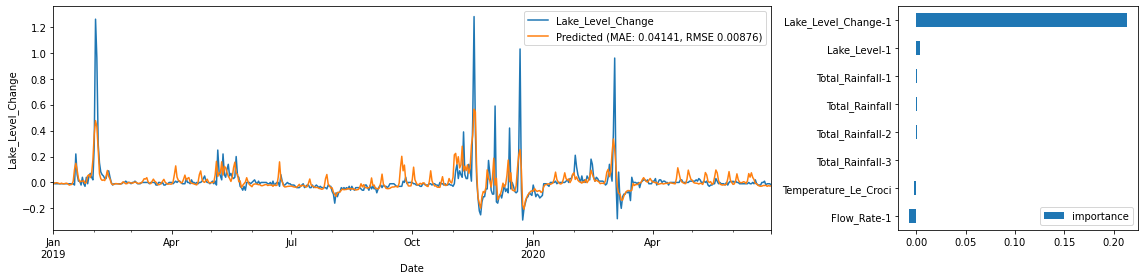

In [23]:
lmPred = linearModel('Lake_Level_Change', base_features + ['Lake_Level_Change-1', 'Lake_Level-1'])

Now that we have a workable model for Lake Level change we can simply add this to yesterday's Lake Level to create predictions for for Lake Level. As we see below the predicted Lake Level has the same MAE as the Lake Level Change and Closely follows the Lake Level. The latter is unsurprising as this is just a 1 step forcast and the more challenging task would be to predic a few more steps. 

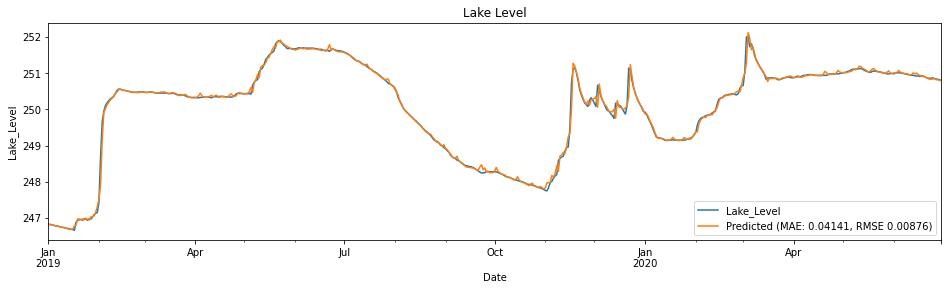

In [24]:
score('Lake_Level', test['Lake_Level'], test['Lake_Level-1']+lmPred, title="Lake Level");

## Less is more
In modeling sometimes less features or less (really better) data gives better results, especially for Linear Regression. We experimented and found that reducing the features to just 'Total_Rainfall-2', 'Temperature_Le_Croci', 'Flow_Rate-1', 'Lake_Level_Change-1', 'Lake_Level-1' (i.e., remove the other lagged rainfalls) yield a lower MAE of 0.03636. 

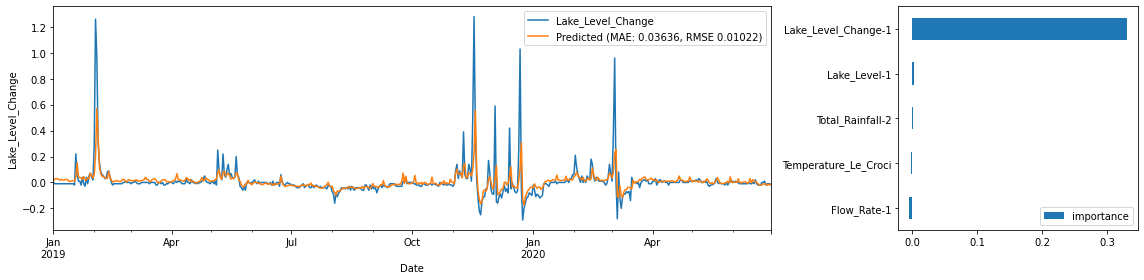

In [25]:
linearModel('Lake_Level_Change', ['Total_Rainfall-2', 'Temperature_Le_Croci', 'Flow_Rate-1', 'Lake_Level_Change-1', 'Lake_Level-1']);

Finally, remembering that in the EDA we notice that the relationship between Flow Rate and Lake Level Changes was different after 2016, we eliminated training before that data and got a much lower MAE of 0.03392, which is 24% better than the baseline. 

We observe below that the predicted Lake Level Change follows the structure well, but again the size of the peak/troughs are wrong. From the feature importance chart see that the prior day's Lake Level Change is the most important driver.

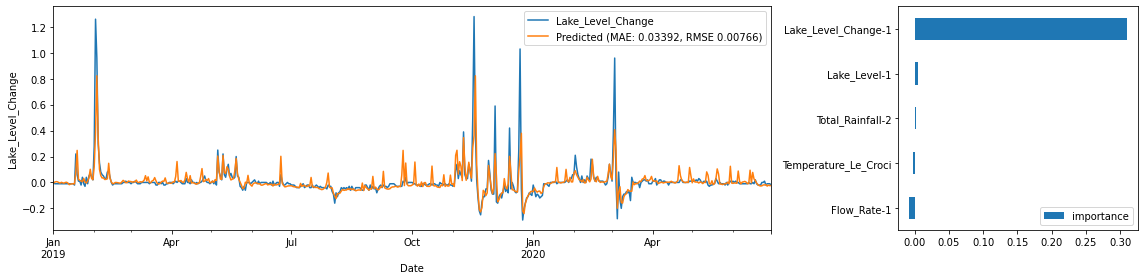

In [26]:
linearModel('Lake_Level_Change', ['Total_Rainfall-2', 'Temperature_Le_Croci', 'Flow_Rate-1', 'Lake_Level_Change-1', 'Lake_Level-1'], fromDate='2016');

## Conclusion
The best linear model has 
- Temperature, which in practice will be a forecast
- Yesterday's Flow_Rate, Lake_Level_Change and Lake_Level
- Day -2 Total Rainfall
- Removes training data prior to 2016

This model has a 24% lower MAE than the baseline.

A key concern is we only forecast the next day's results based on today's known numbers, i.e., one step forecast. It is likely that a multi-step forecast is required, which is possible, however as the model uses lagged data involving the targets, forecasting errors will compound. Furthermore, we would need to forecast rain falls and temperatures. 

# Other types of models
Now that we have a basic understanding of how modeling works in this problem we switch to using Automate ML to find the best type of model then tune the hyperparameters to get the best fit. AutoML removes some of the basic data preparation and modeling work, allowing a data scientist to focuse on the more creative aspects of the problem, such as feature creation. 

To enable a comparison with the prior work we usethe same data ranges and train/test splits. We see below this finds a slightly better Linear Regression model that above, with MAE 0.0334 vs 0.0339, however the best model is Extra Trees Regressor with an MAE of 0.0271, which is 20% better than the best Linear Regression model above and 31% better than the baseline mode!

In [27]:
!pip install pycaret > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kubernetes 10.1.0 requires pyyaml~=3.12, but you have pyyaml 5.3.1 which is incompatible.
jupyterlab-git 0.10.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.0.0 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [28]:
from pycaret.regression import *
train = dfs["Lake_Bilancino"]['2016':'2018']
test  = dfs["Lake_Bilancino"]['2019':'2020']

In [29]:
reg1 = setup(data = train, test_data = test, 
             target = 'Lake_Level_Change', 
             ignore_features=['Lake_Level', 'Flow_Rate', 'Flow_Rate_Change'], #as they are targets to be predicted and not known at the time of the prediction.
             feature_selection=True, remove_multicollinearity=True, 
             fold_strategy='timeseries', data_split_shuffle=False)

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:35:29
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
Rainfall_S_Piero,Numeric
Rainfall_Mangona,Numeric
Rainfall_S_Agata,Numeric
Rainfall_Cavallina,Numeric
Rainfall_Le_Croci,Numeric
Temperature_Le_Croci,Numeric
Total_Rainfall,Numeric
Lake_Level_Change,Label
Year,Categorical
Total_Rainfall-1,Numeric


StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

In [30]:
llcModel = compare_models(cross_validation=False, sort = 'MAE')

NameError: name '_all_models' is not defined

In [31]:
pred = predict_model(llcModel, data = test)
score('Lake_Level_Change', test['Lake_Level_Change'], pred['Label'])
plot_model(llcModel,plot = 'feature');

NameError: name 'llcModel' is not defined

Further experimentation like adding lagged individual rainfalls and removing the Total Rainfall did not improve MAE. We also tried predicting Lake Level, rather than the change, which led to a much higher (worse) 0.0352. The last step is then to "tuning" the best model, which improves the MAE to 0.0262, ie., 3%

In [32]:
llcTunedModel = tune_model(llcModel, optimize = 'MAE')

NameError: name 'llcModel' is not defined

In [33]:
pred = predict_model(llcTunedModel, data = test)
score('Lake_Level_Change', test['Lake_Level_Change'], pred['Label'])
plot_model(llcTunedModel,plot = 'feature');

NameError: name 'llcTunedModel' is not defined

## Flow Rate
We chooe the baseline prediction of using yesterday's Flow Rate, which has an MAE of 0.390.

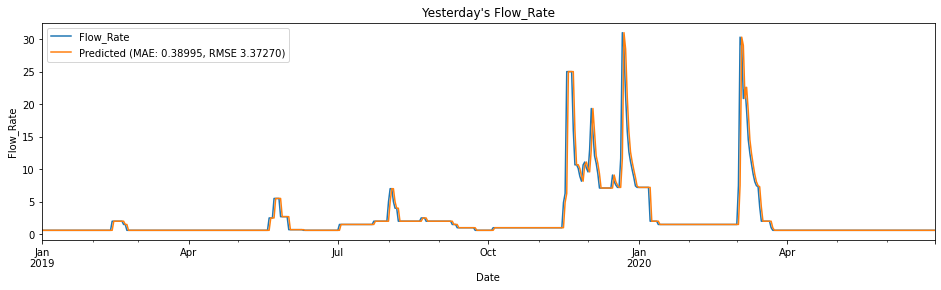

In [34]:
score('Flow_Rate', test['Flow_Rate'], test['Flow_Rate-1'], title="Yesterday's Flow_Rate");

Using AutoML we find the best  model is Huber Regressor	with an MAE of 0.4014, which is 3% worse than the baseline model where  Flow Rate. The feature important shows the predication is predominantly based on the prior day's Flow Rate, with minor modification from the Flow Rate Change and Date. 

The conclusion is the Flow Rate is well predicted using yesterday's flow rate.  The a possible reason this is difficult to model, as proposed, Flow Rate is manually controlled and does not follow a clearly predictable model.

In [35]:
reg1 = setup(data = train, test_data = test, 
             target = 'Flow_Rate', 
             ignore_features=['Lake_Level', 'Lake_Level_Change', 'Flow_Rate_Change'], #as they are targets to be predicted and not known at the time of the prediction.
             feature_selection=True, remove_multicollinearity=True, 
             fold_strategy='timeseries', data_split_shuffle=False)

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:35:29
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
Rainfall_S_Piero,Numeric
Rainfall_Mangona,Numeric
Rainfall_S_Agata,Numeric
Rainfall_Cavallina,Numeric
Rainfall_Le_Croci,Numeric
Temperature_Le_Croci,Numeric
Flow_Rate,Label
Total_Rainfall,Numeric
Year,Categorical
Total_Rainfall-1,Numeric


StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

In [36]:
frModel = compare_models(cross_validation=False, sort = 'MAE')

NameError: name '_all_models' is not defined

In [37]:
pred = predict_model(frModel, data = test)
score('Flow_Rate', test['Flow_Rate'], pred['Label'])
plot_model(frModel,plot = 'feature');

NameError: name 'frModel' is not defined

# Lake Level Change
We find a significantly better prediction using the CatBoost Regressor, which has MAE of 0.0277, which is 10% better than our best previous model.